In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.optim import SGD
from tqdm import tqdm

In [2]:
from neural_ode_solvers import AdjointODE, AutogradODE
from ode_solvers import euler_step

We will be inspecting the following ODE in a 2D space: $r''=-r$

Let's view it as:
$$v'=-r$$
$$r'=v$$

In [3]:
class ODE_equation(nn.Module):
    
    # A function that returns the right parts of an ode equation
    def forward(self, inputs):
        
        t, state = inputs
        r_vec, v_vec = state[:2], state[2:] 
        
        return torch.cat([v_vec, -r_vec])

In [28]:
num_steps = 500
timestamps = np.linspace(0., 10, 101)

In [4]:
# Initial point of the ODE
v0 = torch.Tensor([1., 1.])
r0 = torch.Tensor([1., 0.])
init_state = torch.cat([r0, v0], 0)

In [25]:
# Function for plotting the trajectory. Input a dict {label: trajectory}
def plot_trajectory(trajectories):
    for label in trajectories:
        plt.plot(*trajectories[label][:, :2].T, label=label)
        
    n = trajectory.shape[0]
    plt.plot(np.linspace(-2, 2, n), np.zeros(n), 'k-')
    plt.plot(np.zeros(n), np.linspace(-2, 2, n), 'k-')
    plt.plot(0, 2, 'rx', label='target', lw=20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.legend()
    plt.show()

## 1. Solving the ODE with Euler method

In [5]:
# Neural ODE solver class with regular backpropogation for optimizing
neural_ode = AutogradODE(ode_func=ODE_equation(), timestamps=timestamps, ode_solver=euler_step)

In [6]:
# Forward function computes the trajectory using the ode_solver, in our case Euler step
states_history = neural_ode.forward(init_state)

In [7]:
trajectory = np.stack(states_history)
trajectory.shape

(100, 4)

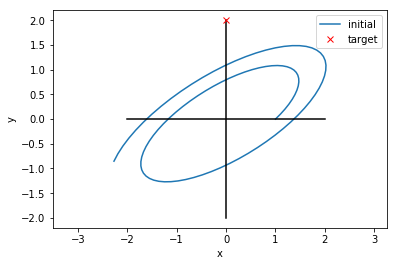

In [26]:
# Plotting one of solutions of the equation
plot_trajectory({"initial": trajectory})

In [29]:
# Fixing the target point of the tragectory. We will be optimizing with regard to this point
v1 = torch.Tensor([1., 1.])
r1 = torch.Tensor([0., 2.])
target_state = torch.cat([r1, v1], 0)

## 2. Оптимизируем обычным градиентным спуском

In [11]:
neural_ode = AutogradODE(ode_func=ODE_equation(), timestamps=timestamps, ode_solver=euler_step)

In [13]:
optimizer = SGD([v0], lr=.01)

In [14]:
loss_history = []
for step in tqdm(range(num_steps)):
    init_state = torch.cat([r0, v0], 0)
    optimizer.zero_grad()
    end_state = neural_ode.forward(init_state)[-1]
    # Optimizing with regard to r coordinates
    loss = torch.sum((end_state[:2] - target_state[:2])**2)  
    loss.backward()
    optimizer.step()
    loss_history.append(loss)

100%|██████████| 300/300 [00:04<00:00, 70.40it/s]


In [15]:
opt_states_history = neural_ode.forward(init_state)
opt_states_history = torch.stack(opt_states_history).detach().numpy()
opt_trajectory = np.stack(opt_states_history)

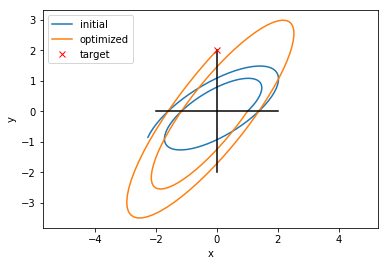

In [27]:
plot_trajectory({"initial": trajectory, "optimized": opt_trajectory})

We have optimized the model with regard to a single train point. This time we used backpropogation with regular gradient calculation.

## 3. Обучим по adjoint методу

In [17]:
# Neural ODE solver with adjoint optimizing method
opt_neural_ode = AdjointODE(ode_func=ODE_equation(), timestamps=timestamps, ode_solver=euler_step)

In [19]:
optimizer = SGD([v0], lr=.05)

In [20]:
loss_history = []
for step in tqdm(range(num_steps)):
    optimizer.zero_grad()
    end_state = opt_neural_ode.forward(init_state)
    # Optimizing with regard to r coordinates
    loss = torch.sum((end_state[:2] - target_state[:2])**2)
    loss.backward()
    optimizer.step()
    loss_history.append(loss)

100%|██████████| 300/300 [00:08<00:00, 36.04it/s]


In [21]:
opt_states_history = neural_ode.forward(init_state)
opt_states_history = torch.stack(opt_states_history).detach().numpy()
opt_trajectory = np.stack(opt_states_history)

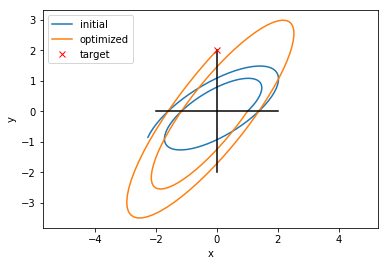

In [22]:
plot_trajectory({"initial": trajectory, "optimized": opt_trajectory})

## Result

This time we tried the adjoint optimizing method that was proposed in the paper https://arxiv.org/pdf/1806.07366.pdf
We checked that our implementation works correcly as model returned the same result as regular backpropogation.